## Model Analysis - Interpretation of results

In [280]:
import os
import sys

sys.dont_write_bytecode = True

import numpy as np
import pandas as pd

from etl import *

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from dotenv import load_dotenv
load_dotenv()

False

loading raw data

In [281]:
DATA_DIR = './Data/'
DATA_FILE = 'spotify_tracks_kaggle_weekly.csv'
ARTIST_FILE = 'spotify_tracks_artist_details.csv'

In [282]:
data_tracks = pd.read_csv(DATA_DIR + DATA_FILE)
data_artist = pd.read_csv(DATA_DIR + ARTIST_FILE)

Merge

In [283]:
data = pd.merge(data_tracks, data_artist, on='track_id', how='left')

Data splitting -> working with predefined $X_{train}$

In [284]:
RANDOM_STATE = 21
TEST_SIZE = 0.1

In [285]:
X = data.drop('popularity', axis=1)
y = data['popularity']

In [286]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

Dropping columns defined in EDA

In [287]:
drop_columns = ['track_id', 'artwork_url', 'track_url', 'track_name']

In [288]:
X_train = X_train.drop(drop_columns, axis=1, errors='ignore')
X_test = X_test.drop(drop_columns, axis=1, errors='ignore')

transformation pipeline

In [289]:
target = 'popularity'

onehot_col = ['language']
circle_of_fifths_col = ['key']
artist_name_col = ['artist_name']
album_name_col = ['album_name']
genre_col = ['artist_genres']
follower_col = ['artist_followers']
artist_popularity_col = ['artist_popularities']


numeric_columns = list(X_train.columns[X_train.dtypes != object].difference(['key', 'mode']))

nan_columns = ['acousticness', 'danceability', 'energy', 'liveness', 'speechiness', 'tempo', 'valence']

In [290]:
numeric_pipeline = Pipeline(steps=[
    ('imputation', SimpleImputer()),
    ('polynomials', PolynomialFeatures()),
    ('scaling', StandardScaler())
])

artist_name_pipeline = Pipeline(steps=[
    ('encoding', FrequencyEncoder()),
    ('imputation', SimpleImputer()),
    ('scaling', StandardScaler())
])

album_name_pipeline = Pipeline(steps=[
    ('encoding', AlbumNameEncoder()),
    ('scaling', StandardScaler())
])

circle_of_fifths_pipeline = Pipeline(steps=[
    ('encoding', CircleOfFifthsEncoding()),
    ('imputation', SimpleImputer())
])

genre_pipeline = Pipeline(steps=[
    ('encoding', GenreEncoder()),
    ('scaling', StandardScaler())
])

followers_pipeline = Pipeline(steps=[
    ('encoding', FollowerCountEncoder()),
    ('scaling', StandardScaler())
])

artist_popularity_pipeline = Pipeline(steps=[
    ('encoding', ArtistPopularityEncoder()),
    ('scaling', StandardScaler())
])


transformations = ColumnTransformer(transformers=[
    
    ('onehot_encoding', OneHotEncoder(sparse_output=False), onehot_col),
    ('trigonometric_encoding', circle_of_fifths_pipeline, circle_of_fifths_col),
    ('artist_encoding', artist_name_pipeline, artist_name_col),
    ('album_encoding', album_name_pipeline, album_name_col),
    ('follower_encoding', followers_pipeline, follower_col),
    ('genres_encoding', genre_pipeline, genre_col),
    ('artist_popularity_encoding', artist_popularity_pipeline, artist_popularity_col),
    ('numeric_processing', numeric_pipeline, numeric_columns)

], remainder='drop').set_output(transform='pandas')


preprocessing = Pipeline(steps=[
    
    ('null_values', ConvertNull(columns=nan_columns)),
    ('transformation', transformations)

]).set_output(transform='pandas')

benchmark pipeline for linear models

In [155]:
DATA_DIR = './Data/'
DATA_FILE = 'spotify_tracks_kaggle_weekly.csv'
ARTIST_FILE = 'spotify_tracks_artist_details.csv'

RANDOM_STATE = 21
TEST_SIZE = 0.1

data_tracks = pd.read_csv(DATA_DIR + DATA_FILE)
data_artist = pd.read_csv(DATA_DIR + ARTIST_FILE)

bm_data = pd.merge(data_tracks, data_artist, on='track_id', how='left').dropna()

X_bm = bm_data.drop('popularity', axis=1)
y_bm = bm_data['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X_bm, y_bm, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

drop_columns = ['track_id', 'artwork_url', 'track_url', 'track_name']

X_train = X_train.drop(drop_columns, axis=1, errors='ignore')
X_test = X_test.drop(drop_columns, axis=1, errors='ignore')

drop_columns = ['track_id', 'artwork_url', 'track_url',
                 'track_name', 'album_name', 'artist_name',
                   'language', 'track_name_x', 'track_name_y',
                   'artist_ids', 'artist_names', 'artist_popularities', 'artist_genres', 'artist_followers']

X_train = X_train.drop(drop_columns, axis=1, errors='ignore')
X_test = X_test.drop(drop_columns, axis=1, errors='ignore')

#### Loading exported models

In [121]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [122]:
from sklearn.metrics import mean_squared_error

In [108]:
DIR = '../../Prod/Models/'

LINEAR = 'Linear/'
ENSEMBLE = 'Ensemble/'

#### Comparison of linear models

In [109]:
benchmark_cols = pd.read_csv(DIR + LINEAR + 'linear-benchmark-columns.csv')['0'].values

In [114]:
bm_lr = joblib.load(DIR + LINEAR + 'linear-benchmark-lr-1.joblib')
bm_ridge = joblib.load(DIR + LINEAR + 'linear-benchmark-ridge-1.joblib')
bm_lasso = joblib.load(DIR + LINEAR + 'linear-benchmark-lasso-1.joblib')

opt_lr = joblib.load(DIR + LINEAR + 'linear-optimized-lr.joblib')
opt_ridge = joblib.load(DIR + LINEAR + 'linear-optimized-ridge.joblib')
opt_lasso = joblib.load(DIR + LINEAR + 'linear-optimized-lasso.joblib')

In [222]:
bm_data = {
    'Linear_regression' : [bm_lr.score(X_train, y_train), bm_lr.score(X_test, y_test), mean_squared_error(y_test, bm_lr.predict(X_test))],
    'Ridge' : [bm_ridge.score(X_train, y_train), bm_ridge.score(X_test, y_test), mean_squared_error(y_test, bm_ridge.predict(X_test))],
    'Lasso' : [bm_ridge.score(X_train, y_train), bm_lasso.score(X_test, y_test), mean_squared_error(y_test, bm_lasso.predict(X_test))]
}

In [228]:
bm_data_df = pd.DataFrame(bm_data).T.rename(columns={0: 'Train R2', 1 : 'Test R2', 2 : 'MSE'})
#bm_data_df.to_csv(DIR + LINEAR + 'benchmark-results.csv')

In [229]:
bm_data_df

,Train R2,Test R2,MSE
Linear_regression,0.116096,0.102582,308.376293
Ridge,0.116096,0.102586,308.374750
Lasso,0.116096,0.074847,317.906593


In [233]:
opt_data = pd.read_csv(DIR + LINEAR + 'optimization-results.csv').set_index('Unnamed: 0')

In [234]:
opt_data

,Train R2,Test R2,MSE
Unnamed: 0,,,
Linear_regression,0.286123,0.261781,253.671275
Ridge,0.286084,0.261508,253.764954
Lasso,0.263422,0.238479,261.678298


In [235]:
bm_data_df['type'] = 'benchmark'
opt_data['type'] = 'optimized'

combined = pd.concat([bm_data_df, opt_data]).reset_index().rename(columns={'index' : 'model'})



In [236]:
combined

,model,Train R2,Test R2,MSE,type
0,Linear_regression,0.116096,0.102582,308.376293,benchmark
1,Ridge,0.116096,0.102586,308.374750,benchmark
2,Lasso,0.116096,0.074847,317.906593,benchmark
3,Linear_regression,0.286123,0.261781,253.671275,optimized
4,Ridge,0.286084,0.261508,253.764954,optimized
5,Lasso,0.263422,0.238479,261.678298,optimized


result plotting

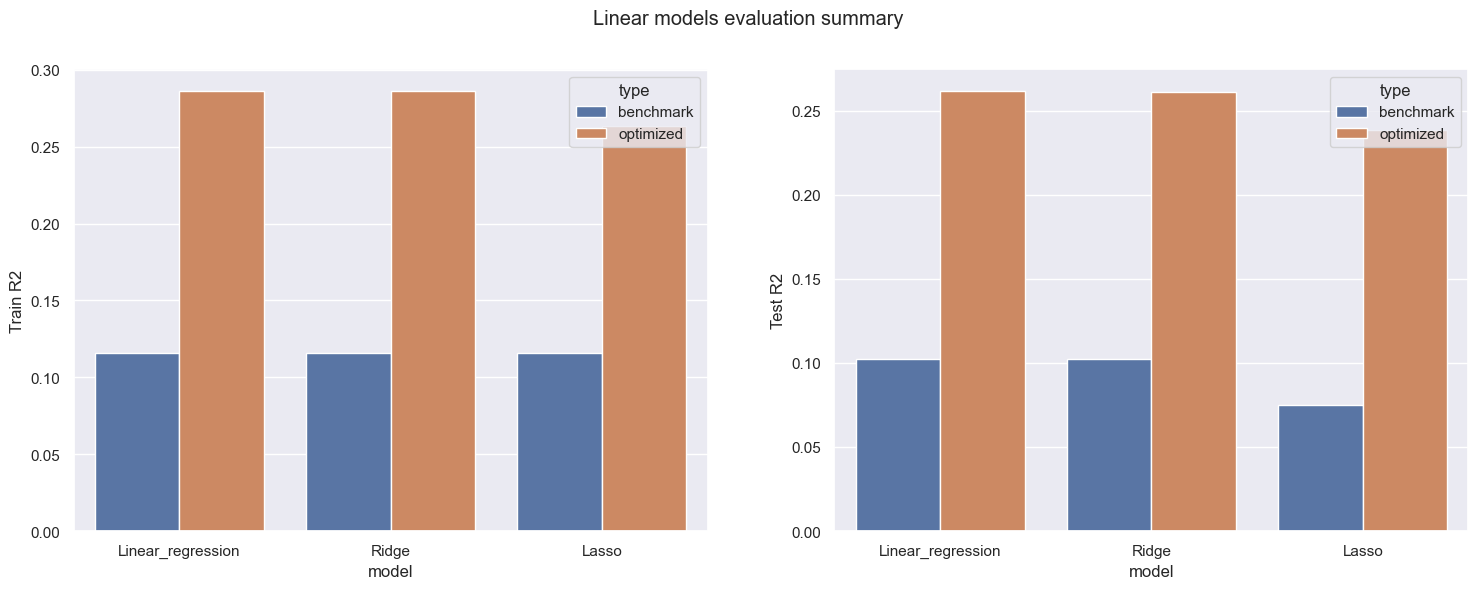

In [278]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(data=combined, x='model', y='Train R2', hue='type', ax=ax[0])
sns.barplot(data=combined, x='model', y='Test R2', hue='type')

fig.suptitle("Linear models evaluation summary")

fig.savefig('../../Prod/Images/linear-models-r2-summary-2.png', bbox_inches='tight')

ridge benchmark vs ridge optimized parameter weights

In [309]:
bm_attr = pd.DataFrame((zip(benchmark_cols, bm_ridge.coef_)))
opt_attr = pd.DataFrame(zip(opt_ridge.named_steps['preprocessing'].transform(X_train).columns, opt_ridge.named_steps['model'].coef_)).sort_values(by=1, ascending=False)

opt_attr[0] = opt_attr[0].str.split('__').str[1]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(21, 6), gridspec_kw={'wspace' : 0.5})

ax[0].set_title('Ridge - benchmark weights')
ax[1].set_title('Ridge - optimized weights (most signifficant)')

sns.barplot(bm_attr.sort_values(by=1, ascending=False), x=1, y=0, color='tab:blue', ax=ax[0])
sns.barplot(data=pd.concat([opt_attr.head(10), opt_attr.tail(10)]), x=1, y=0, color='tab:red', ax=ax[1])

fig.suptitle('Comparison of attribute weights in benchmark & optimal Ridge models')

fig.savefig('../../Prod/Images/linear-models-attribute-weights-2.png', bbox_inches='tight')